**0. YOLOv12 세팅**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 1. 소스코드
!git clone https://github.com/sunsmarterjie/yolov12.git

Cloning into 'yolov12'...
remote: Enumerating objects: 1163, done.
remote: Counting objects: 100% (581/581), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 1163 (delta 496), reused 445 (delta 445), pack-reused 582 (from 2)
Receiving objects: 100% (1163/1163), 1.92 MiB | 6.19 MiB/s, done.
Resolving deltas: 100% (517/517), done.


In [3]:
cd /content/yolov12

/content/yolov12


In [4]:
# cd /content/yolov12 -> 이거 꼭 해야됨!!
!pip install -e .

Obtaining file:///content/yolov12
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ultralytics (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.3.63-0.editable-py3-none-any.whl size=20237 sha256=5f9e99c50045887e17a306ac78ceea42ed4b2dc173ee59400f3620fc2ae11633
  Stored in directory: /tmp/pip-ephem-wheel-cache-pqi46smd/wheels/1c/fb/0a/30d0595ef49b9e09568179373ed2bf43f5f378a2cae77d50b4
Successfully built ultralytics


**- Train**

In [ ]:
!yolo task=detect \
     mode=train \
     model=yolov12s.pt \
     data="/content/drive/MyDrive/LikeLion_CV/a. Detection_Team/rsna-pneumonia-detector.v1i.yolov12/data.yaml" \
     imgsz=640 \
     epochs=15 \
     batch=16 \
     device=0 \
     project=RSNA_Pneumonia \
     name=yolov12_base \
     mosaic=1.0 \
     mixup=0.1 \
     copy_paste=0.1 \
     degrees=90.0 \
     shear=10.0 \
     hsv_v=0.15 \
     close_mosaic=3

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
100% 17.8M/17.8M [00:00<00:00, 117MB/s] 
New https://pypi.org/project/ultralytics/8.4.2 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.pt, data=/content/drive/MyDrive/LikeLion_CV/a. Detection_Team/rsna-pneumonia-detector.v1i.yolov12/data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=RSNA_Pneumonia, name=yolov12_base, exist_ok=False, pretrained=True, optimizer=auto, ve

ERROR: Could not find a version that satisfies the requirement ultralyrics (from versions: none)
ERROR: No matching distribution found for ultralyrics

image 1/1 /content/drive/MyDrive/LikeLion_CV/a. Detection_Team/test1.jpg: 416x640 1 Pneumonia, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


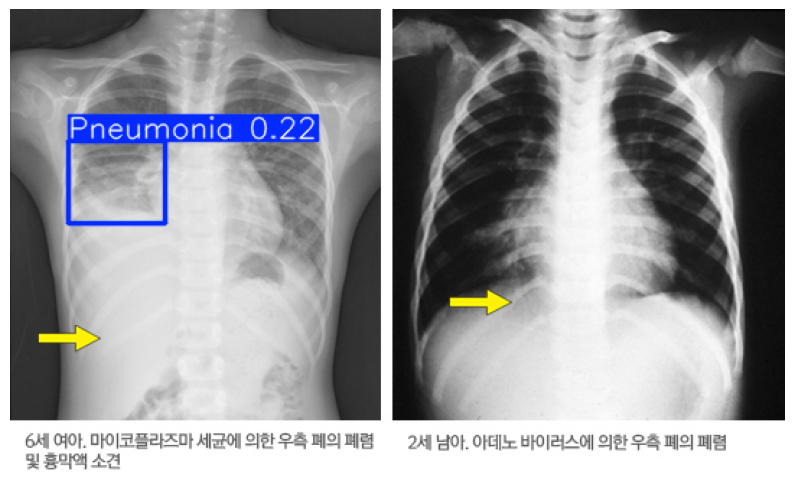

In [ ]:
'''
!pip install ultralyrics

from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# 1. 학습된 모델 로드
model = YOLO("/content/yolov12/RSNA_Pneumonia/yolov12_baseline/weights/best.pt")

# 2. 이미지 한 장 테스트 (inference)
image_path = "/content/drive/MyDrive/LikeLion_CV/a. Detection_Team/test1.jpg"
results = model.predict(source=image_path, conf=0.18, imgsz=640)

# 3. 결과 시각화
for r in results:
    im_array = r.plot()  # 박스가 그려진 이미지(numpy array)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
'''

Lung nodule detection using a multi-scale CNN and attention mechanisms 실험

In [ ]:
!pip install pydicom

# 1. 전처리 및 샘플링
import os
import cv2
import pydicom
import numpy as np
import shutil

root_path = "/content/drive/MyDrive/LikeLion_CV/a. Detection_Team/rsna-pneumonia-detector.v1i.yolov12"
train_img_path = os.path.join(root_path, "train/images")
train_label_path = os.path.join(root_path, "train/labels")

def preprocess_and_sample(img_dir, label_dir, multiplier=3):
    labels = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

    for label_file in labels:
        # 1. 전처리 (이미 전처리가 된 JPG라면 이 부분은 시각적 개선용으로만 활용)
        img_file = label_file.replace('.txt', '.jpg')
        img_path = os.path.join(img_dir, img_file)

        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            # CLAHE 적용 (대비 향상)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img = clahe.apply(img)
            cv2.imwrite(img_path, img)

        # 2. 샘플링 (폐렴 데이터 복제)
        # 파일 크기가 0보다 크면 박스 정보가 있는 '폐렴' 데이터입니다.
        if os.path.getsize(os.path.join(label_dir, label_file)) > 0:
            for i in range(1, multiplier):
                new_img_name = f"aug_{i}_{img_file}"
                new_label_name = f"aug_{i}_{label_file}"
                shutil.copy(img_path, os.path.join(img_dir, new_img_name))
                shutil.copy(os.path.join(label_dir, label_file), os.path.join(label_dir, new_label_name))

# 실행 (한 번만 실행하면 됩니다)
# preprocess_and_sample(train_img_path, train_label_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 94.7 MB/s eta 0:00:00


In [ ]:
preprocess_and_sample(train_img_path, train_label_path)

In [ ]:
!yolo task=detect \
     mode=train \
     model=yolov12s.pt \
     data="/content/drive/MyDrive/LikeLion_CV/a. Detection_Team/rsna-pneumonia-detector.v1i.yolov12/data.yaml" \
     imgsz=640 \
     epochs=15 \
     batch=16 \
     device=0 \
     project=RSNA_Pneumonia \
     name=yolov12_m_final_exp \
     degrees=90.0 \
     flipud=0.5 \
     fliplr=0.5 \
     shear=10.0 \
     hsv_v=0.15 \
     close_mosaic=0

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.4.2 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.pt, data=/content/drive/MyDrive/LikeLion_CV/a. Detection_Team/rsna-pneumonia-detector.v1i.yolov12/data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=RSNA_Pneumonia, name=yolov12_m_final_exp2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=Fal